# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

Exercise 2 and 3

In [ ]:
import pandas as pd

def process_fossil_data(input_file, output_file):
    # read data
    df = pd.read_csv(input_file)

    # filter data
    df = df[~((df['LAT'] == 0) & (df['LONG'] == 0))]
    df = df[~df['SPECIES'].isin(['sp.', 'indet.'])]

    # time range
    mn_units = [
        (23, 21.7, 'MN1'),
        (21.7, 19.5, 'MN2'),
        (19.5, 17.2, 'MN3'),
        (17.2, 16.4, 'MN4'),
        (16.4, 14.2, 'MN5'),
        (14.2, 12.85, 'MN6'),
        (12.85, 11.2, 'MN7-8'),
        (11.2, 9.9, 'MN9'),
        (9.9, 8.9, 'MN10'),
        (8.9, 7.6, 'MN11'),
        (7.6, 7.1, 'MN12'),
        (7.1, 5.3, 'MN13'),
        (5.3, 5, 'MN14'),
        (5, 3.55, 'MN15'),
        (3.55, 2.5, 'MN16'),
        (2.5, 1.9, 'MN17')
    ]

    def assign_mn_unit(min_age, max_age):
        mean_age = (min_age + max_age) / 2
    
        for upper, lower, mn in mn_units:
            if lower <= mean_age < upper:
                return mn
        if mean_age >= mn_units[0][0]:
            return 'pre-MN'
        return 'post-MN'

    df['MN_UNIT'] = df.apply(lambda row: assign_mn_unit(row['MIN_AGE'], row['MAX_AGE']), axis=1)

    df.loc[df['LIDNUM'] == 'Samos Main Bone Beds', 'MN_UNIT'] = 'MN12'
    df.loc[df['LIDNUM'] == 'Can Llobateres I', 'MN_UNIT'] = 'MN9'

    df['SPECIES_ID'] = df.groupby(['GENUS', 'SPECIES']).ngroup() + 1

    df.drop_duplicates(subset=['LIDNUM', 'GENUS', 'SPECIES'], inplace=True)

    # save to csv
    df.to_csv(output_file, index=False)


    num_rows = df.shape[0]
    num_species = df['SPECIES_ID'].nunique()
    num_localities = df['LIDNUM'].nunique()

    print(f"Number of rows: {num_rows}")
    print(f"Number of unique species: {num_species}")
    print(f"Number of unique localities: {num_localities}")

    return df

def main():
    input_file = 'NOWdata.txt'
    output_file = 'cleaned_fossils.csv'
    process_fossil_data(input_file, output_file)

if __name__ == "__main__":
    main()


Number of rows: 62330
Number of unique species: 11263
Number of unique localities: 7120


Exercise 4

In [75]:
import pandas as pd

df = pd.read_csv('cleaned_fossils.csv')
unique_units = df['MN_UNIT'].unique()
print(unique_units)


['MN6' 'pre-MN' 'post-MN' 'MN15' 'MN12' 'MN7-8' 'MN2' 'MN9' 'MN11' 'MN4'
 'MN5' 'MN13' 'MN17' 'MN10' 'MN14' 'MN16' 'MN3' 'MN1']


C:\Users\thech\AppData\Local\Temp\ipykernel_65420\4080574286.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_time_counts = df.groupby(['SPECIES_ID', 'MN_UNIT']).size().unstack(fill_value=0)
C:\Users\thech\AppData\Local\Temp\ipykernel_65420\4080574286.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occurrences_per_unit = df.groupby('MN_UNIT').size().rename('occ_count')
C:\Users\thech\AppData\Local\Temp\ipykernel_65420\4080574286.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(time_unit

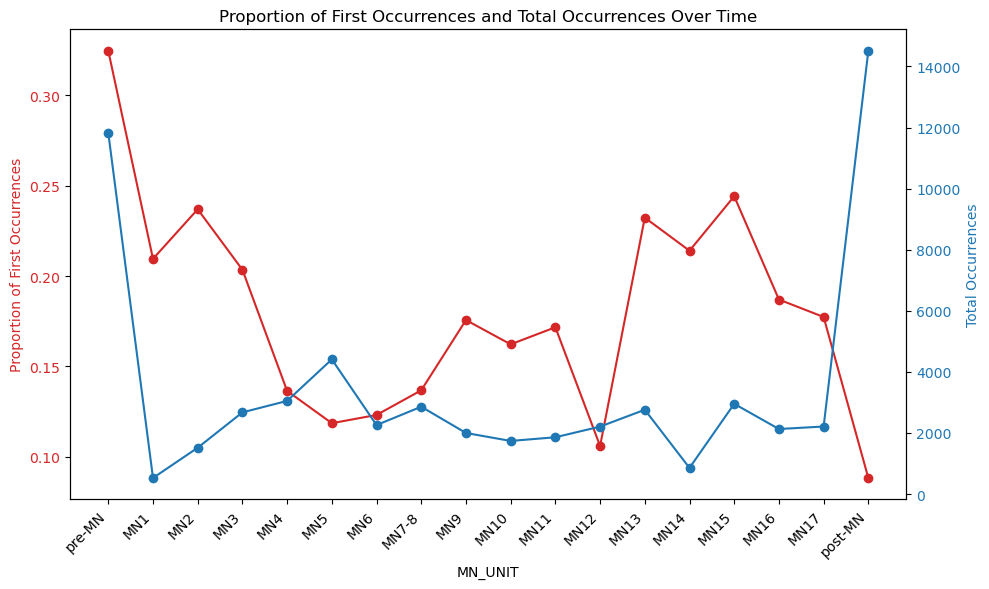

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


df = pd.read_csv('cleaned_fossils.csv')


mn_order = ['pre-MN', 'MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 
            'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'post-MN']

df['MN_UNIT'] = pd.Categorical(df['MN_UNIT'], categories=mn_order, ordered=True)

# number of occurrences per MN unit
species_time_counts = df.groupby(['SPECIES_ID', 'MN_UNIT']).size().unstack(fill_value=0)

def first_occurrence_unit(row):
    occurrences = row[row > 0]
    if len(occurrences) == 0:
        return None
    
    return occurrences.index[0]

first_occurrences = species_time_counts.apply(first_occurrence_unit, axis=1)
first_occurrence_df = pd.DataFrame({'SPECIES_ID': first_occurrences.index, 'FIRST_MN_UNIT': first_occurrences.values})


first_per_unit = first_occurrence_df.groupby('FIRST_MN_UNIT').size().rename('first_occ_count')
occurrences_per_unit = df.groupby('MN_UNIT').size().rename('occ_count')

time_unit_stats = pd.concat([occurrences_per_unit, first_per_unit], axis=1)
time_unit_stats['first_occ_count'] = time_unit_stats['first_occ_count'].fillna(0)

# calculate proportion of first occurrences
time_unit_stats['proportion_first'] = time_unit_stats['first_occ_count'] / time_unit_stats['occ_count']

# 4) plot
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:red'
ax1.set_xlabel('MN_UNIT')
ax1.set_ylabel('Proportion of First Occurrences', color=color)
ax1.plot(time_unit_stats.index, time_unit_stats['proportion_first'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(time_unit_stats.index, rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Occurrences', color=color)
ax2.plot(time_unit_stats.index, time_unit_stats['occ_count'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Proportion of First Occurrences and Total Occurrences Over Time')
plt.tight_layout()
plt.show()


Exercise 5

   LIDNUM MN_UNIT  num_first_occurrences  num_all_occurrences  \
0   10001     MN2                      1                    1   
1   10002     MN3                      2                    3   
2   10003     MN5                      0                    1   
3   10004     MN5                      4                    8   
4   10005     MN6                      0                    1   

   proportion_first_occurrences        LAT       LONG  
0                      1.000000  19.433330 -99.133333  
1                      0.666667  16.898056 -96.414167  
2                      0.000000  17.050000 -96.716667  
3                      0.500000  17.050000 -96.716667  
4                      0.000000  17.050000 -96.716667  


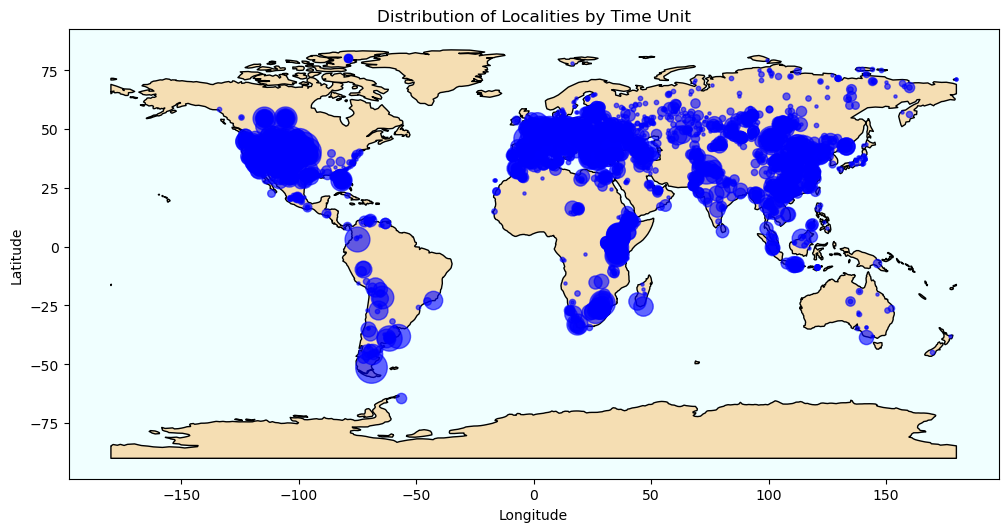

In [108]:

def process_locality_data(input_file, output_file):
    # Load the cleaned fossil data
    df = pd.read_csv(input_file)

    # find the first occurrence of each species
    first_occ = df.groupby(['GENUS', 'SPECIES'])['MN_UNIT'].min().reset_index()
    first_occ.rename(columns={'MN_UNIT': 'FIRST_MN_UNIT'}, inplace=True)
    df = df.merge(first_occ, on=['GENUS', 'SPECIES'], how='left')
    df['Is_First_Occurrence'] = (df['MN_UNIT'] == df['FIRST_MN_UNIT'])
    
    # get unique locality coordinates
    locality_coords = df[['LIDNUM', 'LAT', 'LONG']].drop_duplicates('LIDNUM')

    # groupby LIDNUM and MN_UNIT
    summary = df.groupby(['LIDNUM', 'MN_UNIT']).agg(
        num_first_occurrences=('Is_First_Occurrence', 'sum'),
        num_all_occurrences=('Is_First_Occurrence', 'count')
    ).reset_index()

    # calculate proportion of first occurrences
    summary['proportion_first_occurrences'] = summary['num_first_occurrences'] / summary['num_all_occurrences']
    summary = summary.merge(locality_coords, on='LIDNUM', how='left')

    # save
    summary.to_csv(output_file, index=False)
    return summary

def visualize_localities(locality_summary):
    # Load world map
    world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

    # Plot world map
    fig, ax = plt.subplots(figsize=(12, 6))
    world.plot(ax=ax, color='wheat', edgecolor='black')
    ax.set_facecolor('azure')
    ax.set_title('Distribution of Localities by Time Unit')

    
    for _, row in locality_summary.iterrows():
        ax.scatter(row['LONG'], row['LAT'], s=row['num_all_occurrences'] * 5, alpha=0.6, color='blue')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

def main():
    input_file = 'cleaned_fossils.csv'
    output_file = 'locality_summary.csv'

    # Process locality data
    locality_summary = process_locality_data(input_file, output_file)
    print(locality_summary.head())

    # Visualize the localities
    visualize_localities(locality_summary)

if __name__ == "__main__":
    main()


Exercise 6

In [111]:
import pandas as pd

def get_previous_mn_unit(mn_unit, mn_order):
    # get the index of the current unit in the mn_order list
    idx = mn_order.index(mn_unit)
    if idx == 0:
        return None
    else:
        return mn_order[idx-1]

def process_exercise_6(df_merged, locality_df, mn_order):

    df_by_mn = {unit: df_merged[df_merged['MN_UNIT'] == unit] for unit in mn_order if unit in df_merged['MN_UNIT'].unique()}
    
    # add new columns to locality_df
    locality_df['occurrences_in_area_this_unit'] = 0
    locality_df['first_occurrences_in_area_this_unit'] = 0
    locality_df['occurrences_in_area_previous_unit'] = 0

    for i, row in locality_df.iterrows():
        focal_lat = row['LAT']
        focal_long = row['LONG']
        focal_unit = row['MN_UNIT']

        # define the area of interest
        lat_min, lat_max = focal_lat - 5, focal_lat + 5
        long_min, long_max = focal_long - 5, focal_long + 5

        # find the current unit
        if focal_unit in df_by_mn:
            df_current_unit = df_by_mn[focal_unit]
            df_area_current = df_current_unit[(df_current_unit['LAT'] >= lat_min) & (df_current_unit['LAT'] <= lat_max) &
                                              (df_current_unit['LONG'] >= long_min) & (df_current_unit['LONG'] <= long_max)]
            occurrences_this = len(df_area_current)
            first_occ_this = df_area_current['is_first_occ'].sum()
        else:
            occurrences_this = 0
            first_occ_this = 0

        # find the previous unit
        prev_unit = get_previous_mn_unit(focal_unit, mn_order)
        if prev_unit and prev_unit in df_by_mn:
            df_prev_unit = df_by_mn[prev_unit]
            df_area_prev = df_prev_unit[(df_prev_unit['LAT'] >= lat_min) & (df_prev_unit['LAT'] <= lat_max) &
                                        (df_prev_unit['LONG'] >= long_min) & (df_prev_unit['LONG'] <= long_max)]
            occurrences_prev = len(df_area_prev)
        else:
            occurrences_prev = 0

    
        locality_df.at[i, 'occurrences_in_area_this_unit'] = occurrences_this
        locality_df.at[i, 'first_occurrences_in_area_this_unit'] = first_occ_this
        locality_df.at[i, 'occurrences_in_area_previous_unit'] = occurrences_prev

    return locality_df

locality_df = pd.read_csv('locality_summary.csv')
mn_order = ['pre-MN', 'MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 
            'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'post-MN']


# add the new columns to locality_df
locality_df = process_exercise_6(df_merged, locality_df, mn_order)

# save the updated locality_df
locality_df.to_csv('locality_summary_updated.csv', index=False)
print(locality_df.head())


   LIDNUM MN_UNIT  num_first_occurrences  num_all_occurrences  \
0   10001     MN2                      1                    1   
1   10002     MN3                      2                    3   
2   10003     MN5                      0                    1   
3   10004     MN5                      4                    8   
4   10005     MN6                      0                    1   

   proportion_first_occurrences        LAT       LONG  \
0                      1.000000  19.433330 -99.133333   
1                      0.666667  16.898056 -96.414167   
2                      0.000000  17.050000 -96.716667   
3                      0.500000  17.050000 -96.716667   
4                      0.000000  17.050000 -96.716667   

   occurrences_in_area_this_unit  first_occurrences_in_area_this_unit  \
0                              1                                    1   
1                              7                                    4   
2                              9               

Exercise 7

Optimization terminated successfully.
         Current function value: 0.588494
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                27318
Model:                          Logit   Df Residuals:                    27316
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 0.05767
Time:                        02:52:48   Log-Likelihood:                -16076.
converged:                       True   LL-Null:                       -17060.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1452      0.019     -7.591      0.000      -0.183      -0.108
x1            -0.0019   4.94e

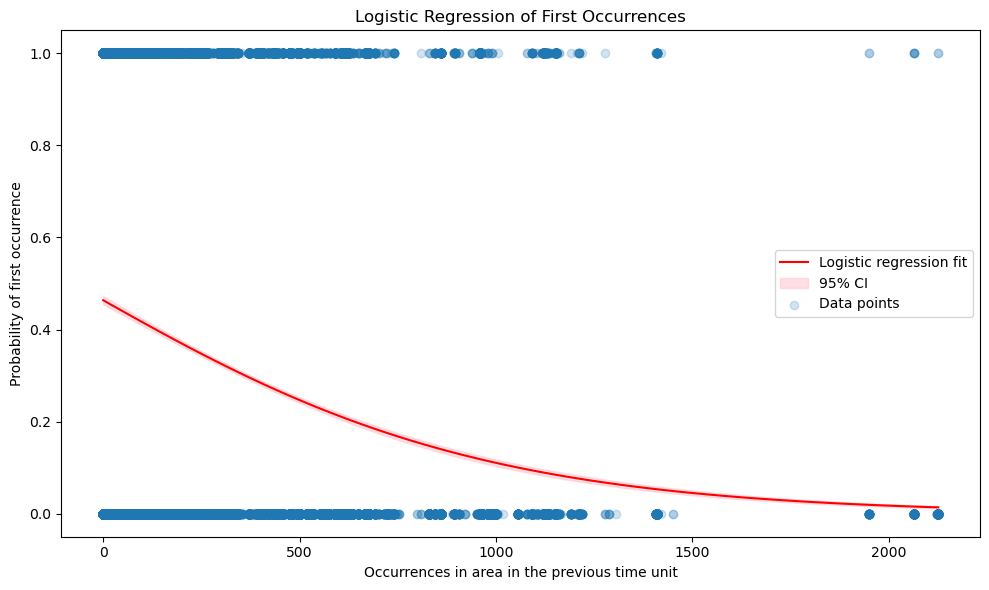

In [ ]:

import statsmodels.api as sm

df_with_area = df_merged.merge(locality_df[['LIDNUM', 'MN_UNIT', 'occurrences_in_area_previous_unit']],
                               on=['LIDNUM','MN_UNIT'], how='left')

# filter MN_UNITs
time_filter_units = mn_order[mn_order.index('MN2'):]
df_filtered = df_with_area[df_with_area['MN_UNIT'].isin(time_filter_units)]

# filter -25 < LONG < 40, LAT > 35
df_filtered = df_filtered[(df_filtered['LONG'] > -25) & (df_filtered['LONG'] < 40) & (df_filtered['LAT'] > 35)]

# occurrences_in_area_previous_unit as X
# is_first_occ as y
regression_data = df_filtered[['occurrences_in_area_previous_unit','is_first_occ']].dropna()
X = regression_data['occurrences_in_area_previous_unit'].values
y = regression_data['is_first_occ'].astype(int).values

# add constant
X_df = pd.DataFrame({
    'const': 1,
    'x1': X
})

# logistic regression
model = sm.Logit(y, X_df)
result = model.fit()
print(result.summary())

# get coefficients and 95% confidence intervals
coefficients = result.params
conf_95 = result.conf_int(alpha=0.05)

b0, b1 = coefficients['const'], coefficients['x1']

x_plot = np.linspace(0, np.max(X), 100)
z = b0 + b1*x_plot
p_pred = 1 / (1 + np.exp(-z))

# calculate confidence interval
cov = result.cov_params()
var_b0 = cov.loc['const','const']
var_b1 = cov.loc['x1','x1']
cov_b0_b1 = cov.loc['const','x1']

var_z = var_b0 + (x_plot**2)*var_b1 + 2*x_plot*cov_b0_b1
std_z = np.sqrt(var_z)

z_low = z - 1.96*std_z
z_high = z + 1.96*std_z

p_low = 1/(1+np.exp(-z_low))
p_high = 1/(1+np.exp(-z_high))

# plot
plt.figure(figsize=(10,6))
plt.plot(x_plot, p_pred, color='red', label='Logistic regression fit')
plt.fill_between(x_plot, p_low, p_high, color='pink', alpha=0.5, label='95% CI')
plt.scatter(regression_data['occurrences_in_area_previous_unit'], regression_data['is_first_occ'], 
            alpha=0.2, label='Data points')
plt.xlabel('Occurrences in area in the previous time unit')
plt.ylabel('Probability of first occurrence')
plt.title('Logistic Regression of First Occurrences')
plt.legend()
plt.show()


Exercise 8

In [ ]:
def predict_first_occurrence_proportion(x):
    # x为occurrences_in_area_previous_unit
    z = b0 + b1 * x
    p = 1 / (1 + np.exp(-z))
    return p

europe_locality_df = locality_df.copy()
europe_locality_df = europe_locality_df[(europe_locality_df['LONG'] > -25) & 
                                        (europe_locality_df['LONG'] < 40) &
                                        (europe_locality_df['LAT'] > 35)]

# calculate expected proportion of first occurrences
europe_locality_df['expected_proportion_first_occurrences'] = europe_locality_df['occurrences_in_area_previous_unit'].apply(predict_first_occurrence_proportion)

print("Europe localities expected proportion of first occurrences calculated and saved.")
print(europe_locality_df.head())

Europe localities expected proportion of first occurrences calculated and saved.
      LIDNUM MN_UNIT  num_first_occurrences  num_all_occurrences  \
1030   20001   MN7-8                      4                   54   
1031   20002     MN6                      5                   80   
1032   20003     MN6                     11                   39   
1033   20004   MN7-8                     14                   89   
1034   20005     MN5                      1                   31   

      proportion_first_occurrences        LAT       LONG  \
1030                      0.074074  48.686400  10.062200   
1031                      0.062500  43.900000  -0.500000   
1032                      0.282051  39.976800  28.307100   
1033                      0.157303  45.600533   5.232575   
1034                      0.032258  48.100000   2.150000   

      occurrences_in_area_this_unit  first_occurrences_in_area_this_unit  \
1030                           1101                                  167 

Exercise 9

In [ ]:
from scipy.stats import binom
# calulate the probability of observing first occurrences
def calc_p_value(row):
    n = row['occurrences_in_area_this_unit']          
    k = row['first_occurrences_in_area_this_unit']    
    p = row['expected_proportion_first_occurrences']  
    return binom.sf(k-1, n, p)

europe_locality_df['p_value'] = europe_locality_df.apply(calc_p_value, axis=1)

print(europe_locality_df[['LIDNUM','MN_UNIT','p_value']].head())


      LIDNUM MN_UNIT       p_value
1030   20001   MN7-8  9.999994e-01
1031   20002     MN6  5.279872e-23
1032   20003     MN6  9.950276e-01
1033   20004   MN7-8  1.000000e+00
1034   20005     MN5  9.999999e-01


Exercise 10

C:\Users\thech\AppData\Local\Temp\ipykernel_65420\3037704126.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


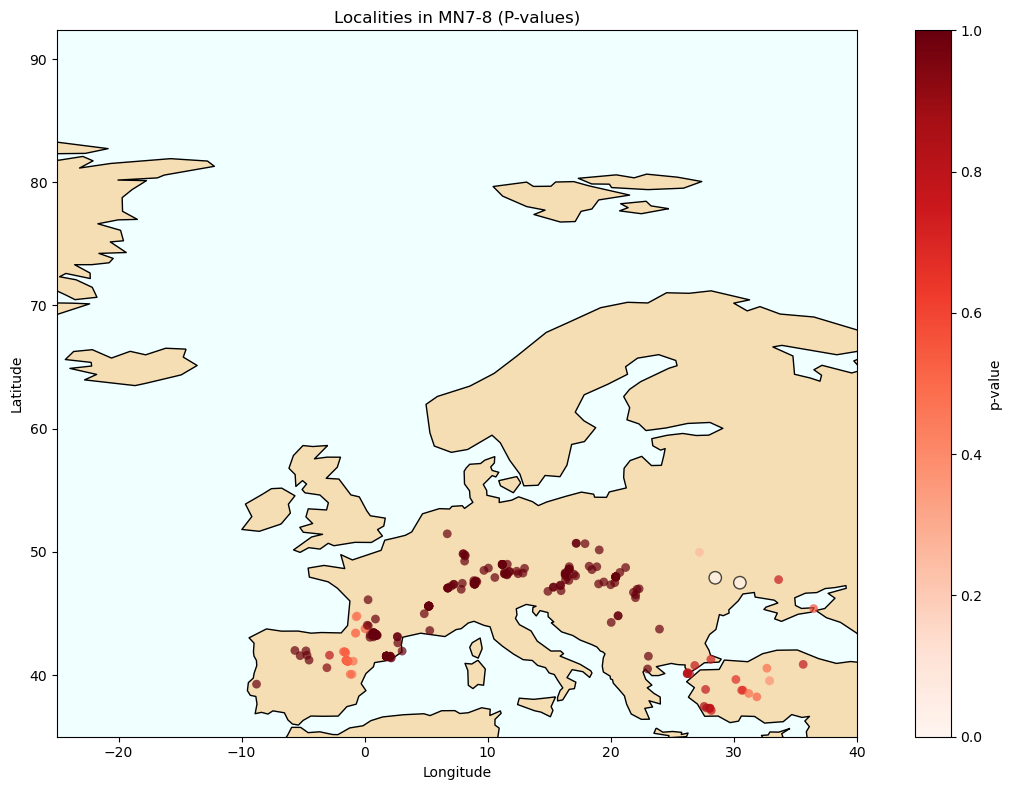

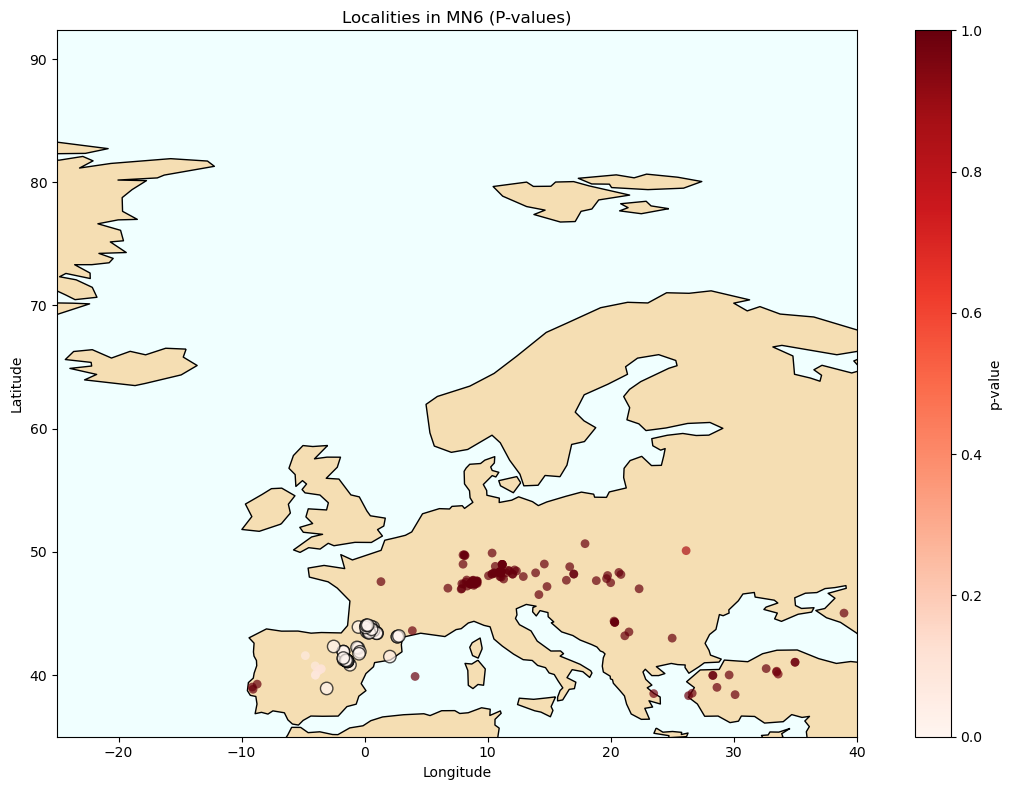

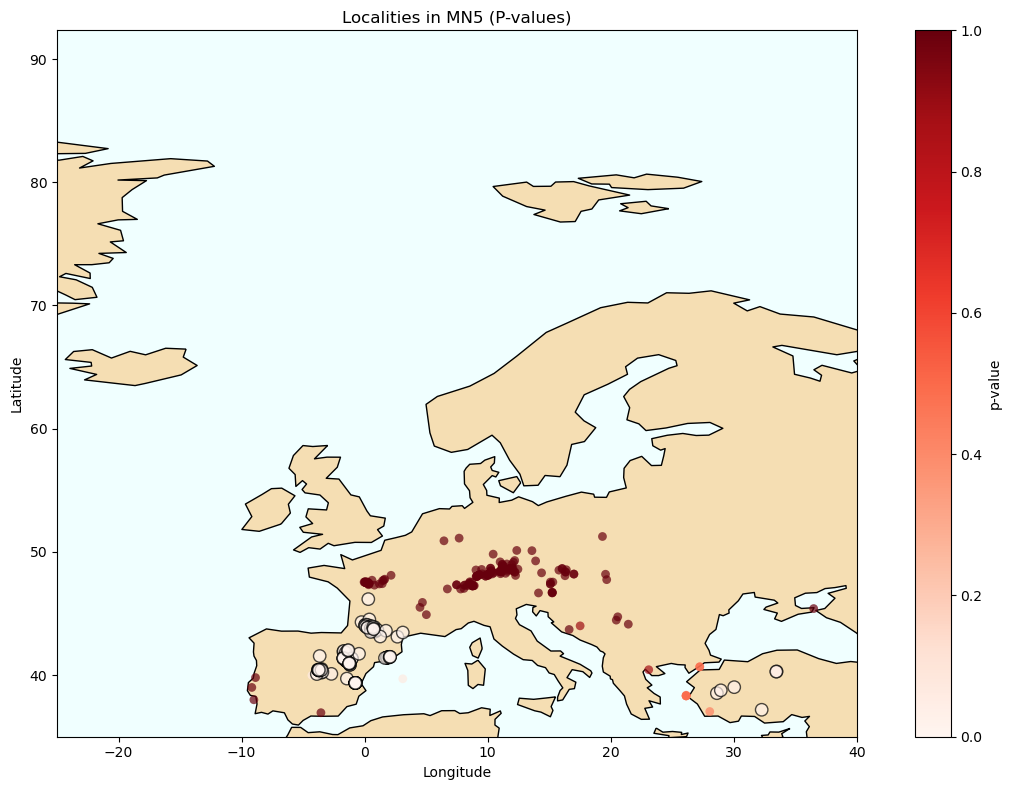

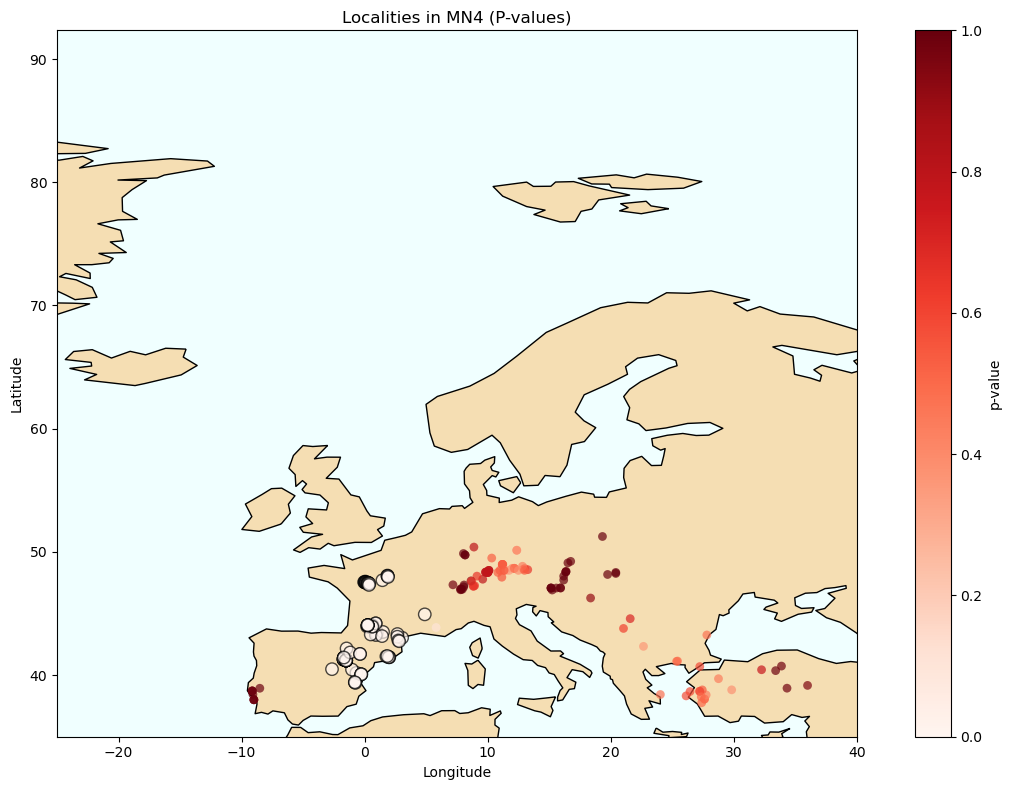

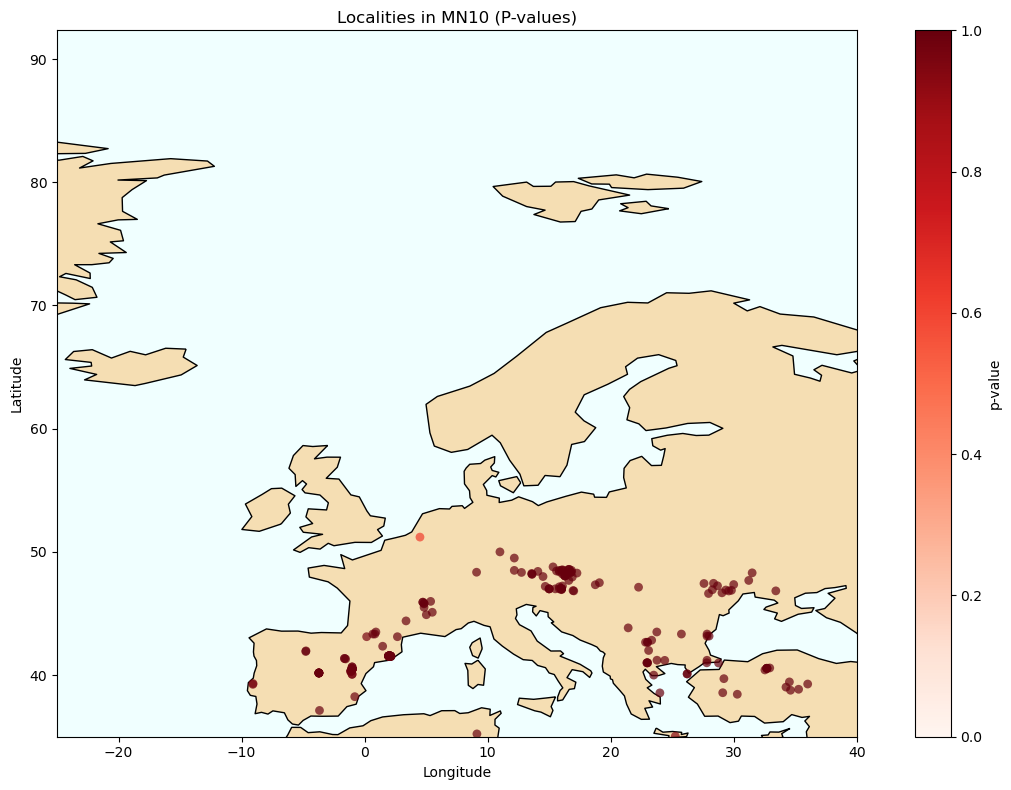

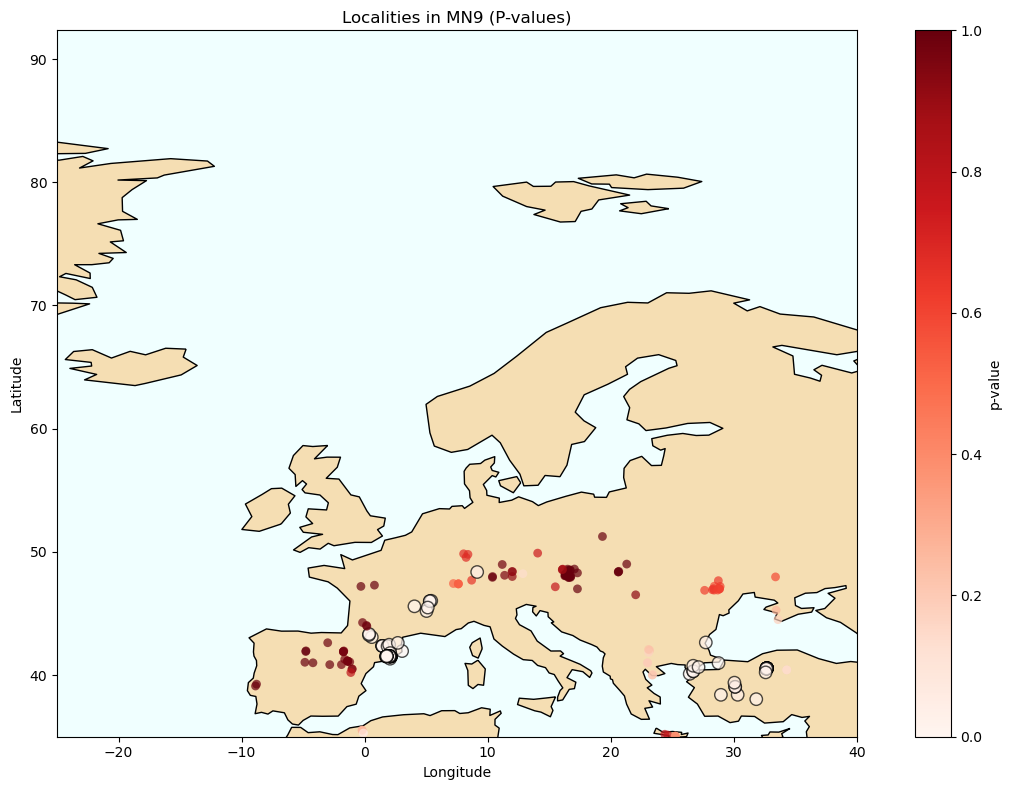

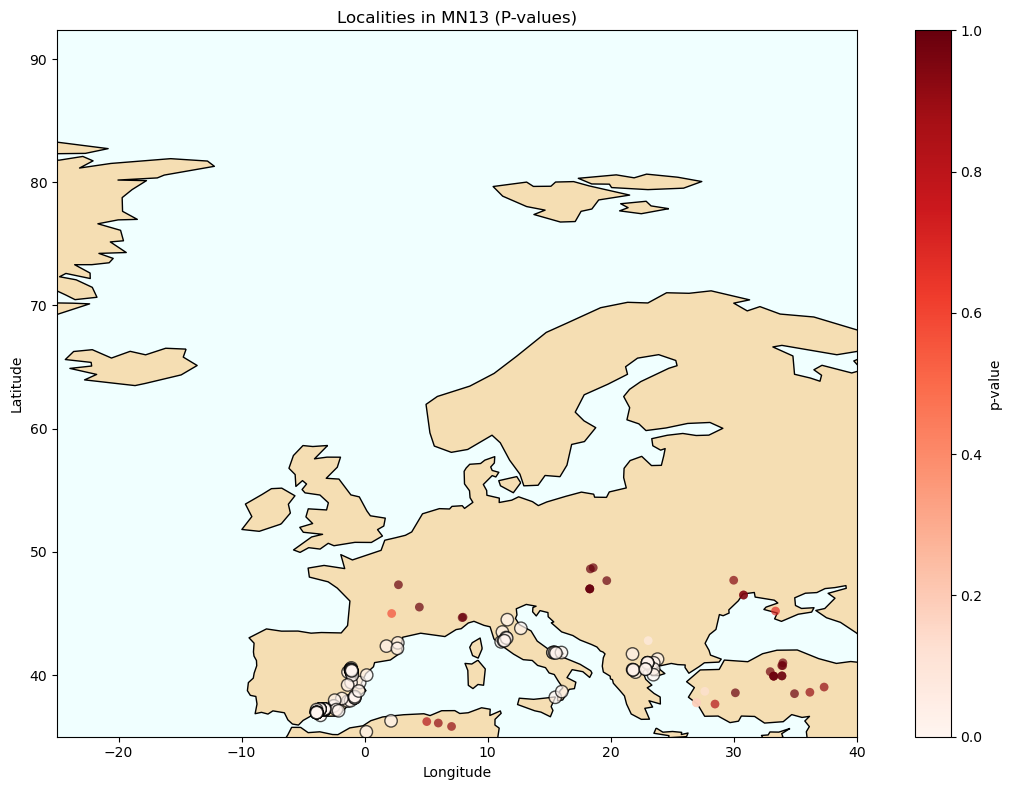

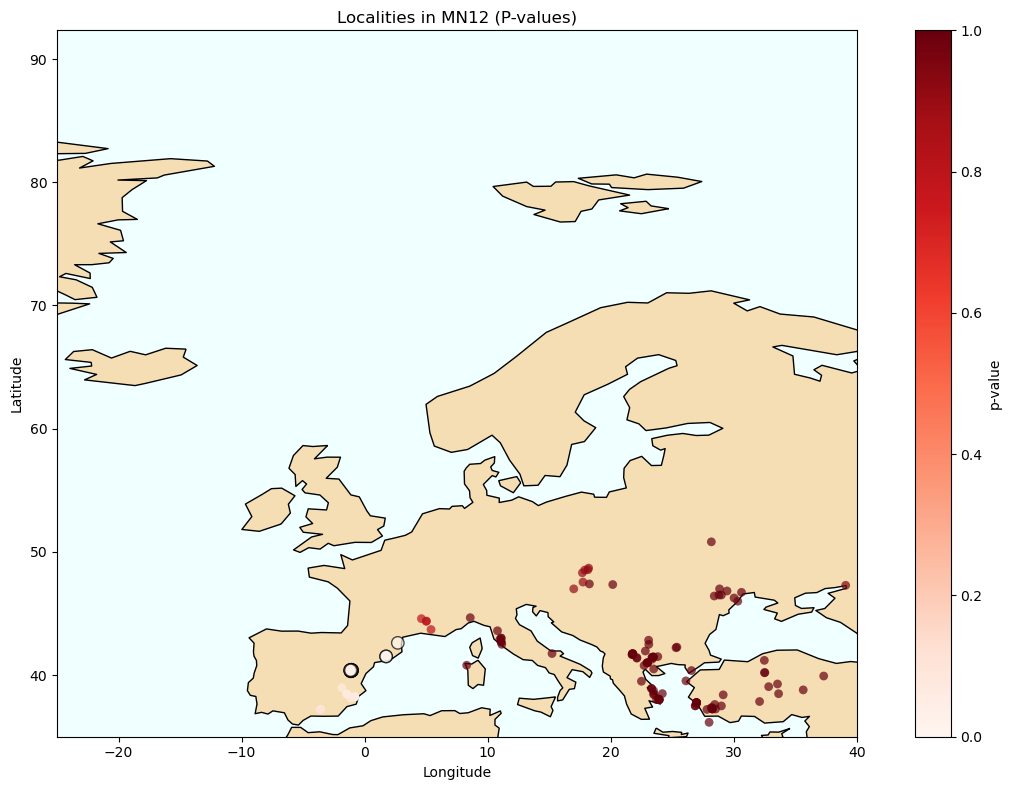

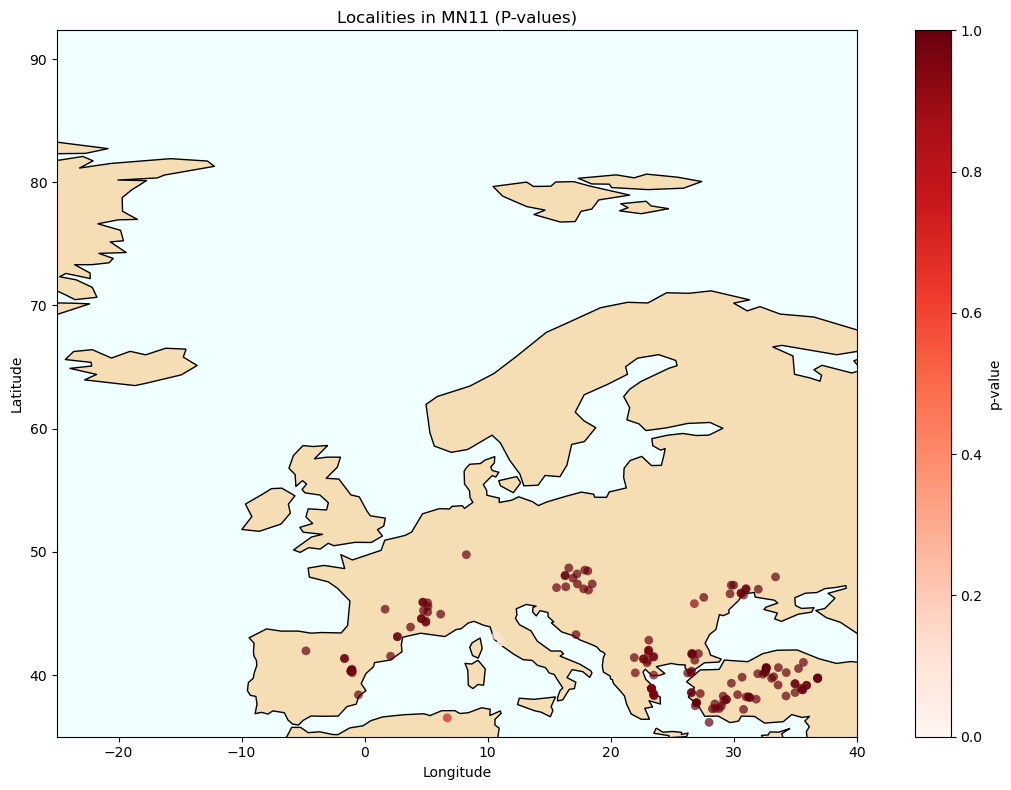

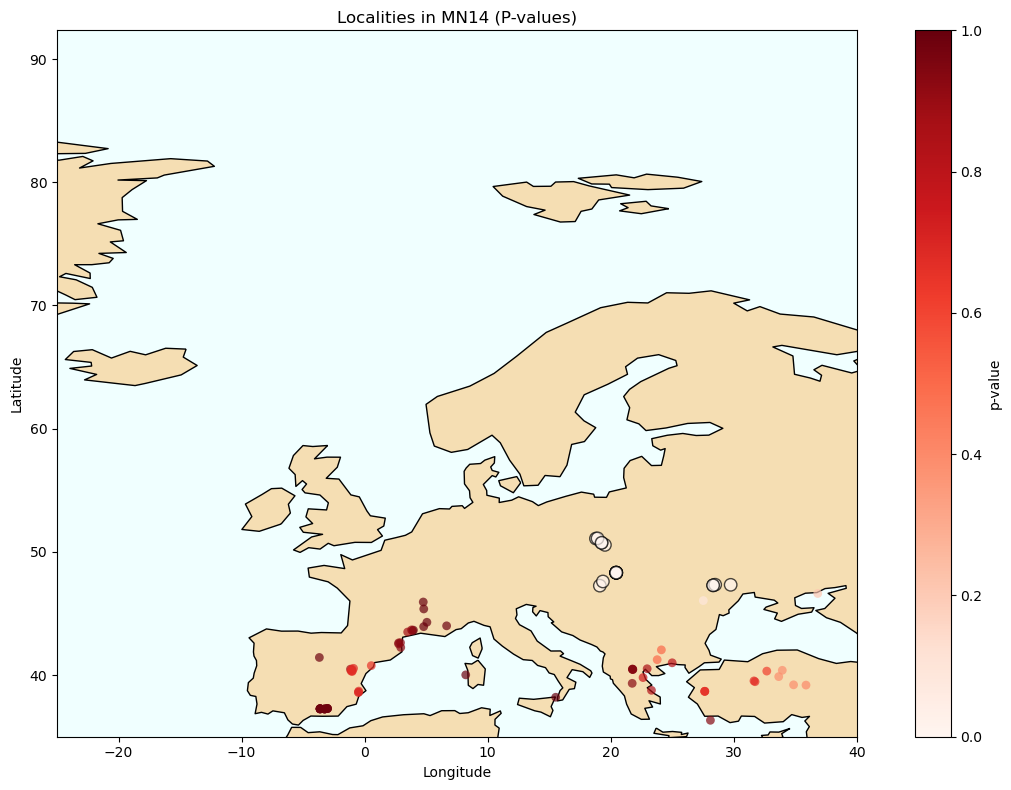

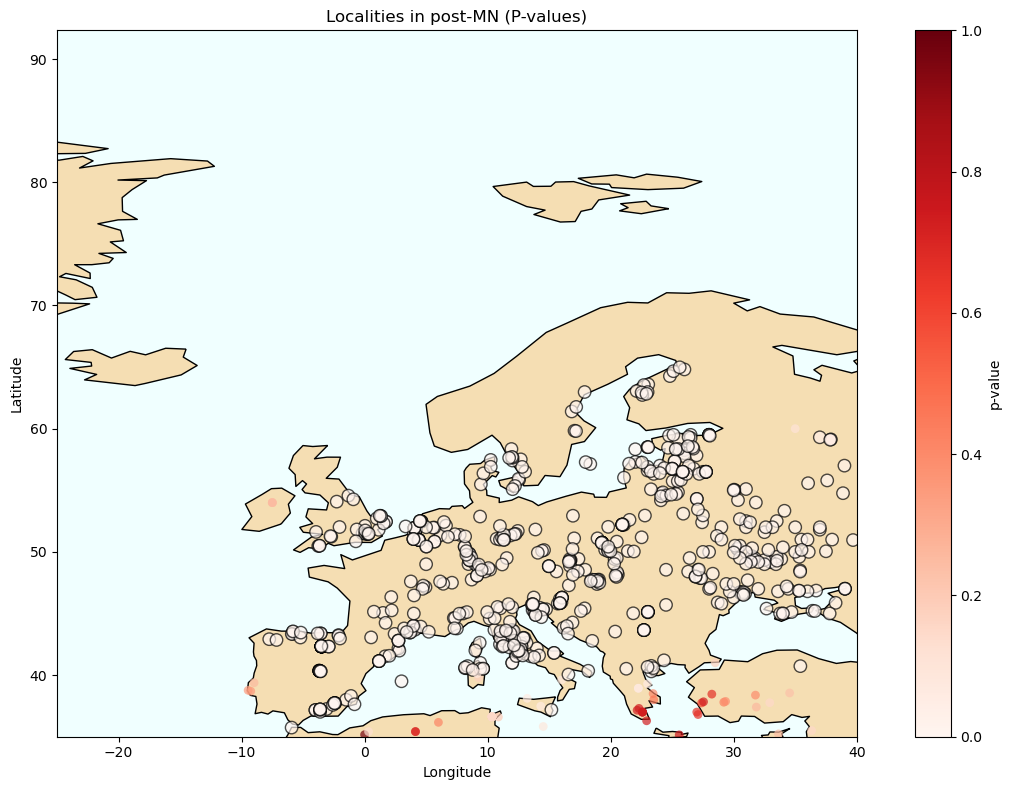

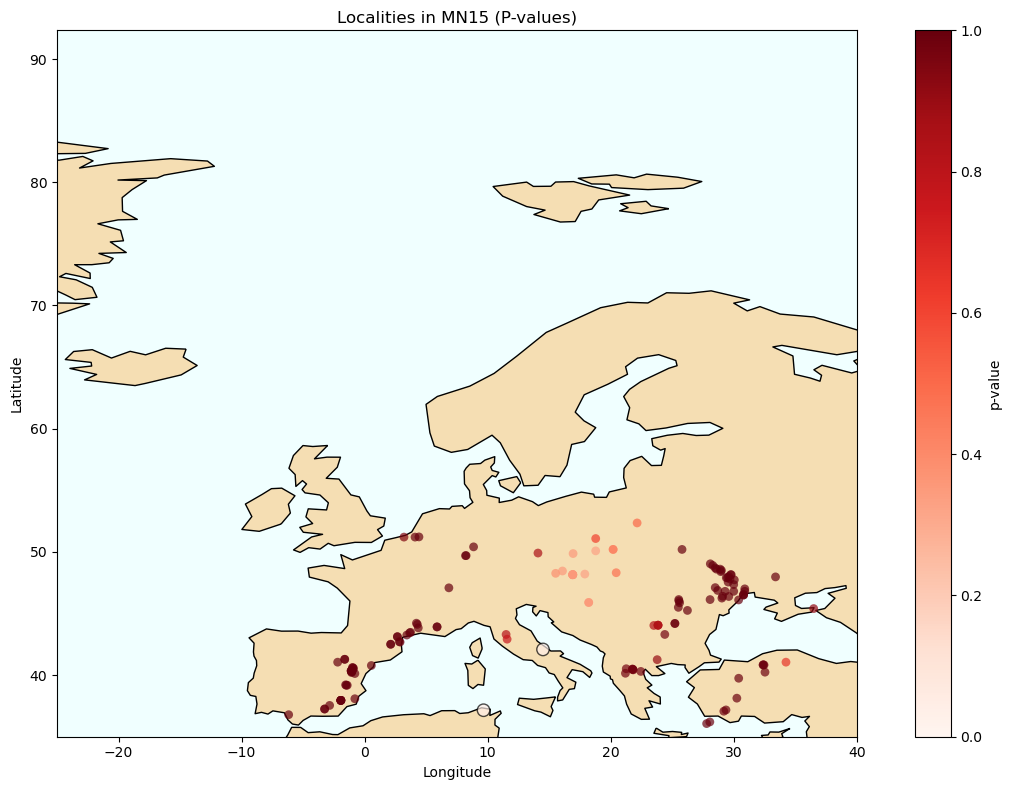

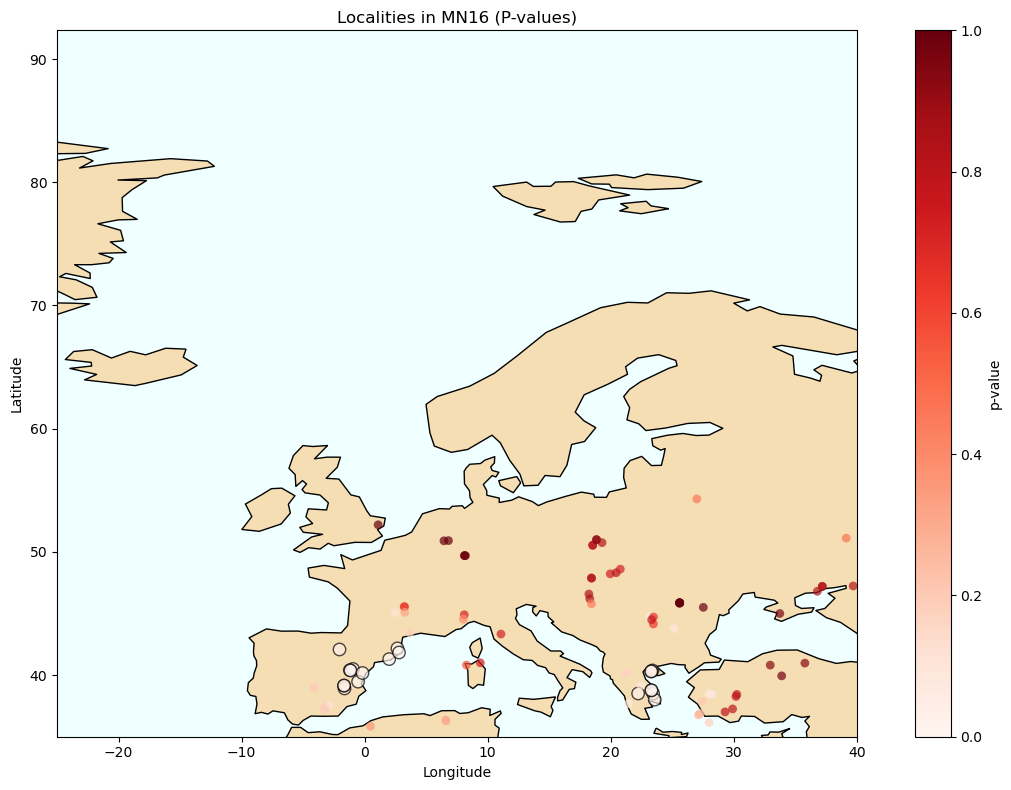

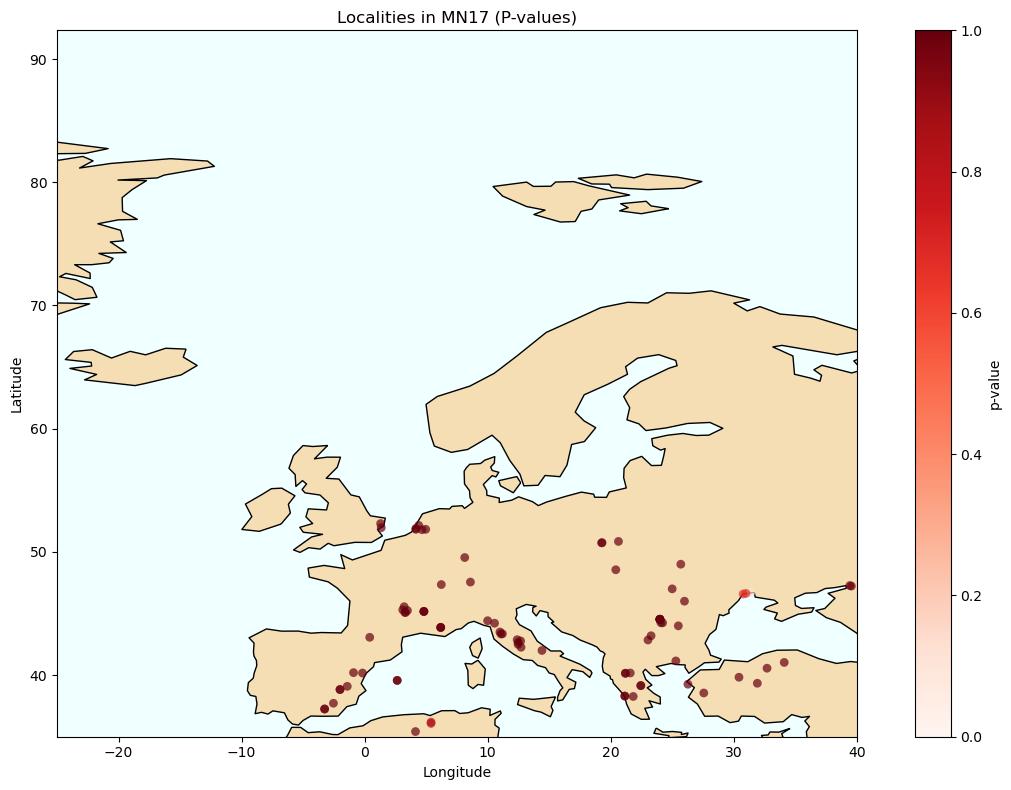

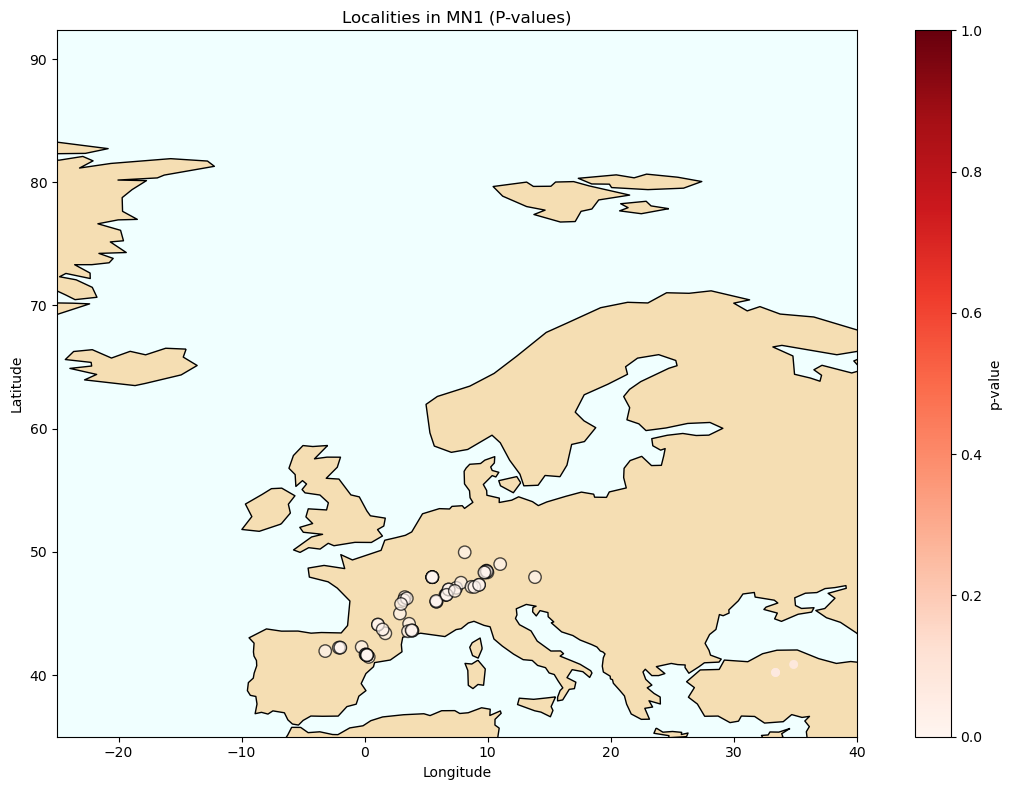

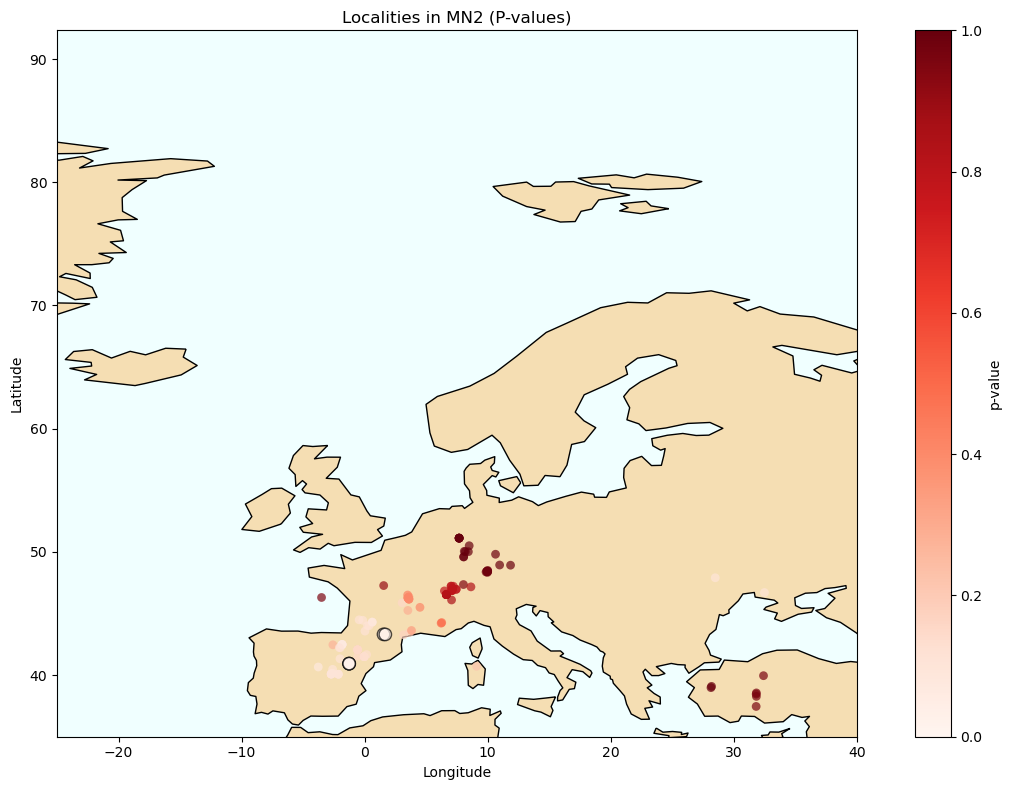

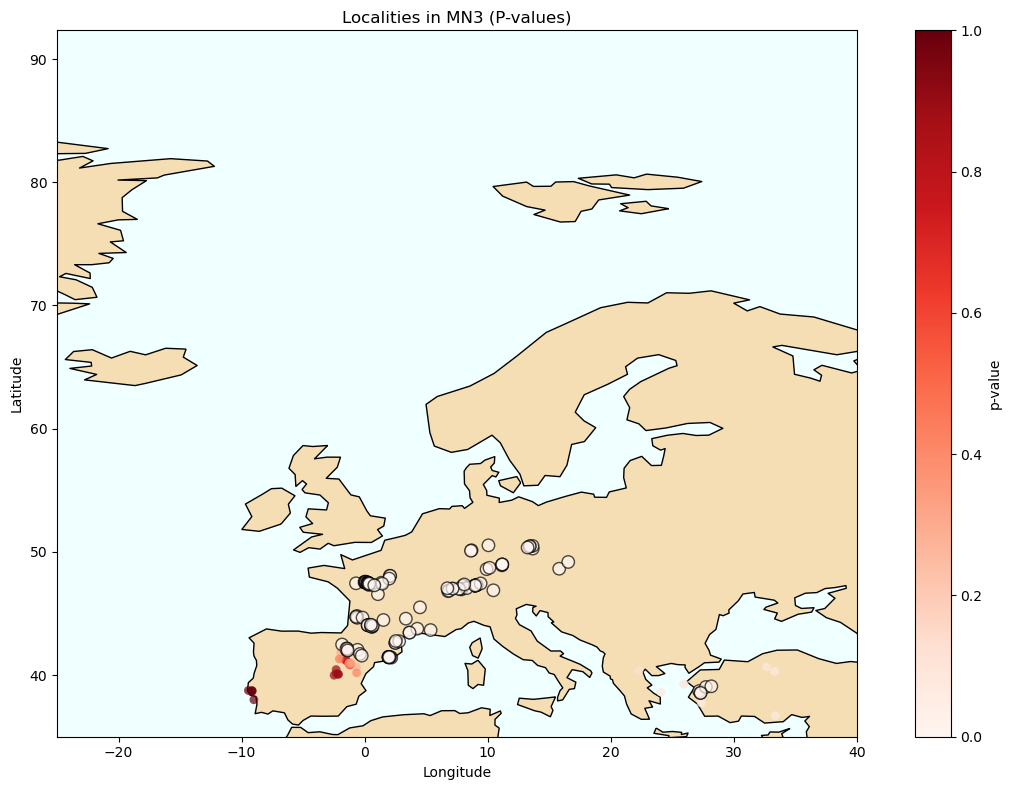

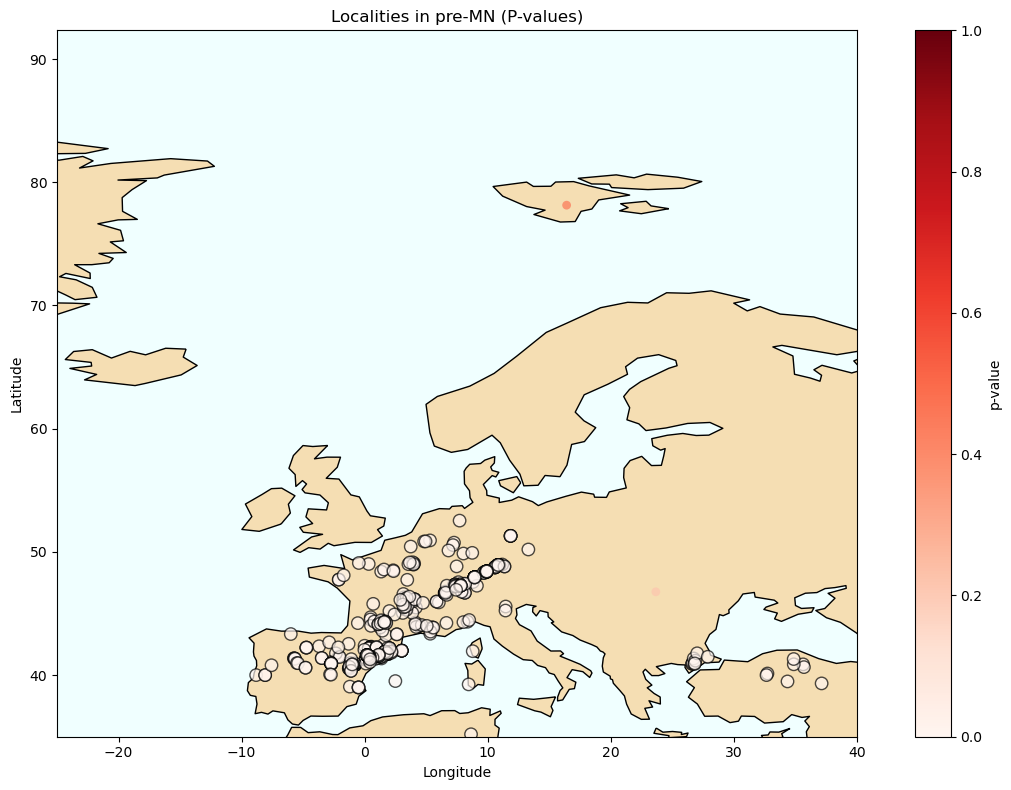

In [126]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# load world map
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# ranges -25 < LONG < 40, LAT > 35)
x_min, x_max = -25, 40
y_min, y_max = 35, world['geometry'].bounds['maxy'].max()

# get unique time units
time_units = europe_locality_df['MN_UNIT'].unique()

# colormap
cmap = plt.cm.get_cmap('Reds')

for unit in time_units:
    # filter data for the time unit
    df_unit = europe_locality_df[europe_locality_df['MN_UNIT'] == unit]

    fig, ax = plt.subplots(figsize=(12,8))
    # plot world map
    world.plot(ax=ax, color='wheat', edgecolor='black')
    ax.set_facecolor('azure')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, None)  


    p_values = df_unit['p_value'].values
    p_values_clipped = np.clip(p_values, 0, 1)  
    colors = cmap(p_values_clipped)

    # set point of p_value < 0.05
    significant = p_values < 0.05
    sizes = np.where(significant, 80, 40)
    edgecolors = np.where(significant, 'black', 'none')
    linewidths = np.where(significant, 1, 0)

    # plot points
    sc = ax.scatter(df_unit['LONG'], df_unit['LAT'], 
                    c=colors, s=sizes, edgecolors=edgecolors, linewidths=linewidths, alpha=0.7)

    plt.title(f'Localities in {unit} (P-values)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # colorbar
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label('p-value')

    plt.tight_layout()
    plt.show()
